## Dimensionality Reduction

In this notebook, we will try various dimensionality reduction techniques to see which, if any, can extract the essential features we will use for our clustering.

The following techniques will be explored:
- Principal Component Analysis (PCA)
- Kernal (nonlinear) PCA
- t-SNE (t-distributed stochastic neighbour embedding)
- Isomap (Isometric mapping)
- UMAP (Uniform manifold approximation and projection)


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly_express as px

from sklearn.decomposition import PCA, KernelPCA
import umap
from sklearn.manifold import Isomap

from sklearn.pipeline import FeatureUnion, Pipeline





import pickle


/home/marcjb/anaconda3/envs/player_analysis/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# Pickled file is dictionary containing 2 items: column names and data 
data = pickle.load( open('../models/transformed_opta_data.p', "rb") )

In [18]:
# Check format
column_names=data[0]
pl_data= data[1]

In [32]:
print(len(pl_data)) # Just checking if it makes sense

3496



#### Part I: PCA

Low-dimensional dataset shape: (3504, 30)


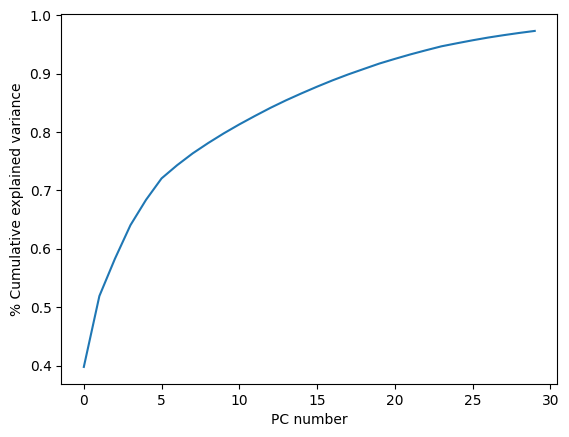

In [15]:
# Try some PCA
pca_compon = 30 # Number of PCA components to test (see if we can get 90% variance)
pca = PCA(n_components=pca_compon)
pca_data = pca.fit_transform(pl_data)

print('Low-dimensional dataset shape: {}'.format(pca_data.shape))

# See how well PCs explain variance in the dataset
cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explained_variance)
plt.xlabel('PC number')
# plt.set_xticks()
plt.ylabel('% Cumulative explained variance')
plt.show()

# Find the loading matrix (relation between original features and principals compon) 
pca_cols = [f'PCA_{comp+1}' for comp in range(pca_compon) ]
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=pca_cols, index=column_names)

# And then find the features that contribute largest magnitude to pca vectors
coeff = pca.components_


In [6]:
# Check loading matrix to see most heavily weighted components 
pca_num = 1 # PCA component you want to check

pc_comp = 'PCA_'+str(pca_num)
loading_matrix[pc_comp].sort_values(ascending=False).head(10)

ProgPassRec             0.966941
PropPress Att 3rd       0.948924
Prop Att 3rd Touches    0.918936
Misplayed/Carry         0.908426
PropAssistShots         0.904708
Prop Att Pen Touches    0.903092
PropCPA                 0.891376
Displaced/Carry         0.889920
PropPassinPA            0.825549
PropShort               0.825454
Name: PCA_1, dtype: float64

In [7]:
#...and check components that contribute in opposite direction
loading_matrix[pc_comp].sort_values(ascending=True).head(10)

Rec%           -0.939378
PropMed        -0.867247
Clr            -0.860004
TotDist/pass   -0.793683
TotPassAtt     -0.766404
Recov          -0.718713
Int            -0.709848
DuelWin%       -0.706944
PropBlockSh    -0.689648
PrgDist/Pass   -0.658885
Name: PCA_1, dtype: float64

Additional ideas taken from [here](https://towardsdatascience.com/how-to-select-the-best-number-of-principal-components-for-the-dataset-287e64b14c6d#:~:text=If%20our%20sole%20intention%20of,variables%20in%20the%20original%20dataset)

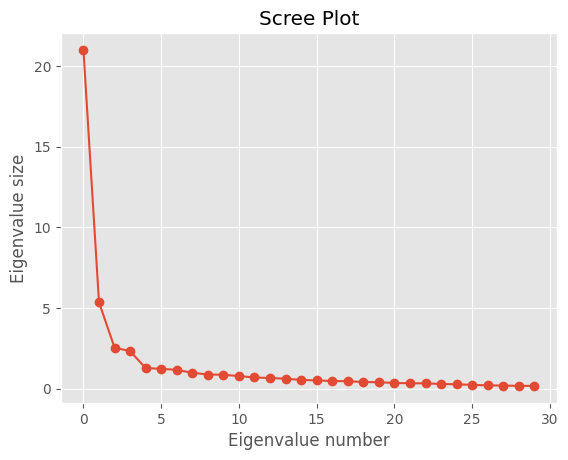

In [8]:
# Scree plot, keep values just before elbow
plt.style.use("ggplot") 
plt.plot(pca.explained_variance_, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")
plt.show()

In [9]:
#...or keep components with eigenvalue greater than 1
print(pca.explained_variance_) # Recommen

[21.00507973  5.36091594  2.54839488  2.32778354  1.28013988  1.23521641
  1.16706518  0.99113889  0.87840164  0.86783208  0.78156587  0.6952895
  0.66335696  0.62209932  0.54176508  0.51710702  0.47443575  0.46801334
  0.41217776  0.40496528  0.35161212  0.33908808  0.33059177  0.29473114
  0.27275804  0.23806116  0.20649261  0.19424444  0.17756138  0.17269555]


Based on above, we will keep 8 components, which gives about 80% of explained variance 

In [10]:
pca_compon = 8 # Number of PCA components
pca = PCA(n_components=pca_compon)
pca_data = pca.fit_transform(pl_data)

pickle.dump(pca_data, open('../models/data/pca_data.p', "wb"))

In [11]:
# Plot what the transformed data looks like (check for clusters)

pca_cols = [f'PCA_{comp+1}' for comp in range(pca_compon) ]
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
player_df = pd.DataFrame(pca_data, columns=pca_cols)

pca = PCA(n_components=8)
components = pca.fit_transform(pca_data)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    player_df, x='PCA_1', y='PCA_2', z='PCA_3', 
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}, 
)
fig.show()

#### Part II: Kernel PCA

Since we can use a different kernel each time (*i.e* a different way of transforming data), we'll test a bunch and see which ones perform best

In [12]:
print(len(pl_data[0]))

77


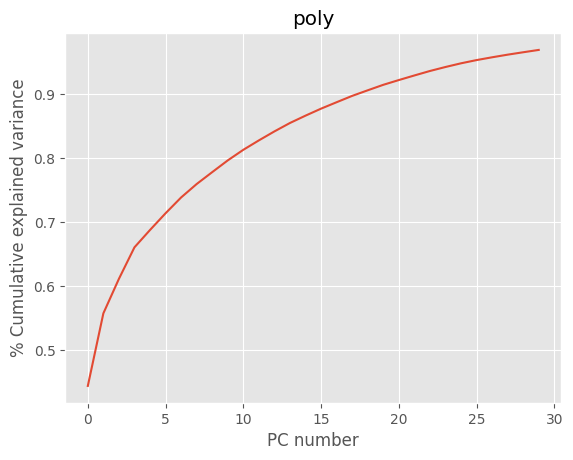

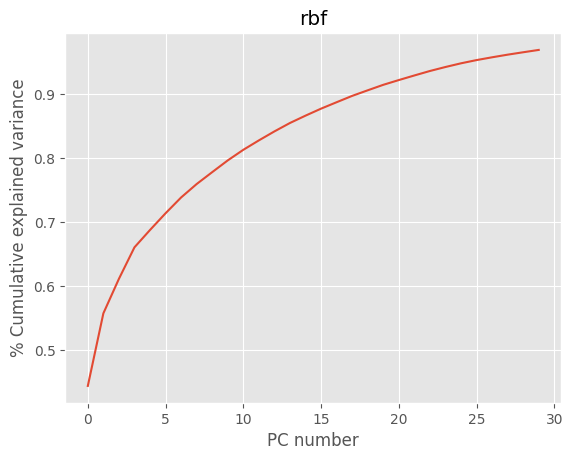

In [13]:
kernel_list =  ['poly', 'rbf']

# Find ratio of explained variance as metric of good reduction (define as function, then pass to grid search)
def kpca_scores(X_transform, y=None):
    # kpca_transform = estimator.fit_transform(X)
    explained_variance = np.var(X_transform, axis=0)
    explained_variance_ratio = explained_variance / np.sum(explained_variance)
    cumul_sum = np.cumsum(explained_variance_ratio)
    return cumul_sum


# Grid search doesn't seen to work, so I'm just gonna use a super inefficient loop

for kernel_type in kernel_list:
    kpca = KernelPCA(kernel = kernel_type)
    X_transform = kpca.fit_transform(pl_data)
    # print(f'Explained variance ratio for thing is {kpca_scores(X_transform)}')
    explained_variance = kpca_scores(X_transform)
    plt.plot(cum_explained_variance)
    plt.xlabel('PC number')
    plt.ylabel('% Cumulative explained variance')
    plt.title(kernel_type)
    plt.show()

I don't think it mattered...OK, next?

#### Part III: UMAP

Functions/ideas taken from [here](https://umap-learn.readthedocs.io/en/latest/parameters.html)

In [20]:
# Function to visualize embeddings in 2-dimensions
def draw_umap(data, n_neighbors=35, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data)
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)))
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1])
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], s=100)
        
    plt.title(title, fontsize=18)
    return u

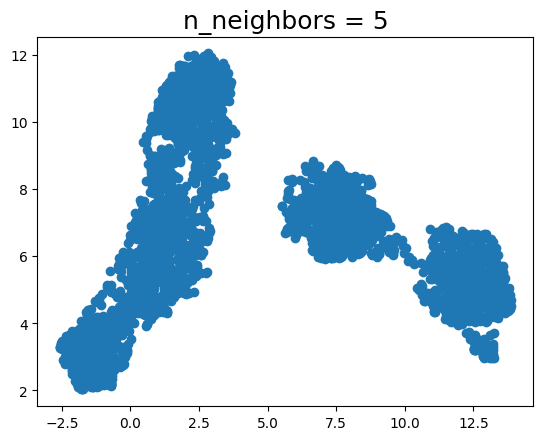

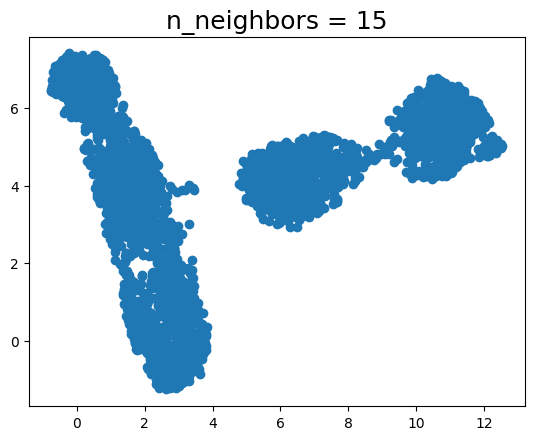

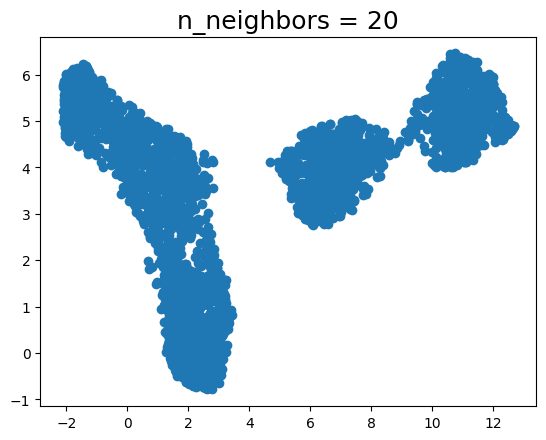

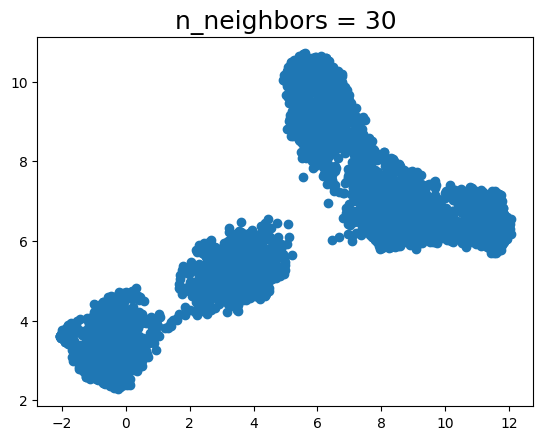

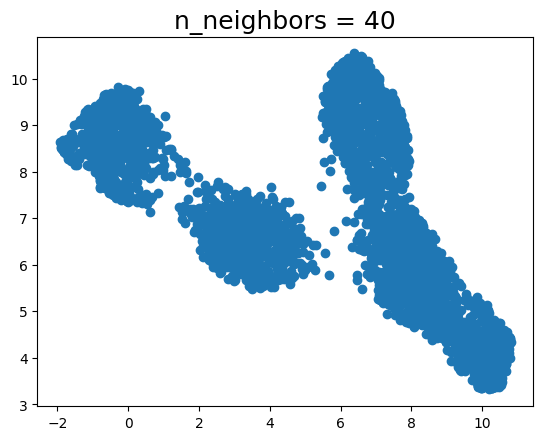

In [19]:
#n_neighbors -> local vs. global structure
for n in (5, 15, 20, 30, 40):
    draw_umap(pl_data, n_neighbors=n, title='n_neighbors = {}'.format(n))

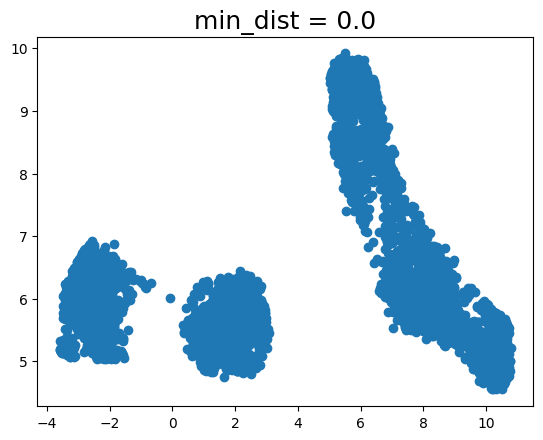

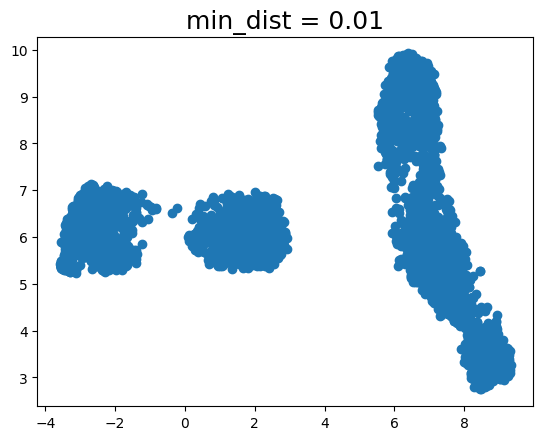

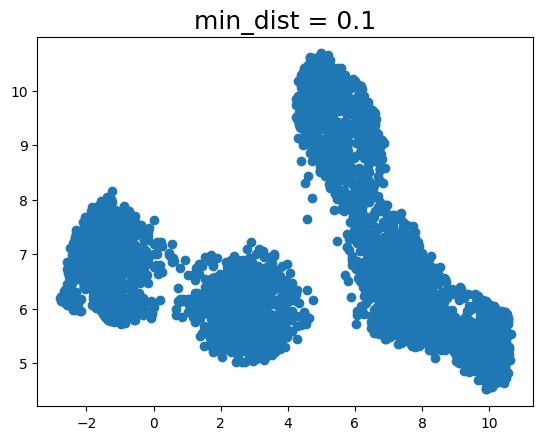

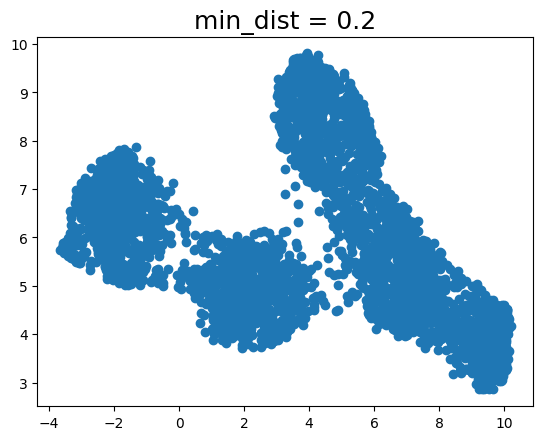

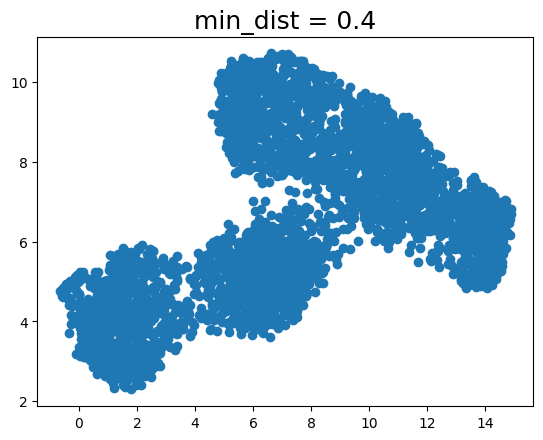

In [21]:
#min_dist -> how close together points are (low numbers better for clustering)
for d in (0.0, 0.01, 0.1, 0.2, 0.4):
    draw_umap(pl_data, min_dist=d, title='min_dist = {}'.format(d))

array([[ 5.616014 ],
       [ 5.8161736],
       [15.888443 ],
       ...,
       [19.089468 ],
       [20.131105 ],
       [ 6.1744037]], dtype=float32)

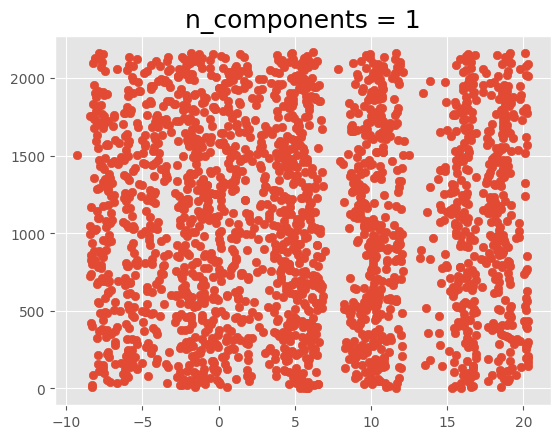

In [17]:
# n_components -> dimensions we embed into; 1d is a line 
draw_umap(pl_data, n_components=1, title='n_components = 1')


array([[ 6.2835884,  4.885246 ,  7.827802 ],
       [ 6.3451114,  4.842458 ,  7.683174 ],
       [ 9.660657 ,  6.712721 ,  5.694468 ],
       ...,
       [10.728243 ,  5.2985396,  7.000043 ],
       [11.262069 ,  6.7383995,  6.3243012],
       [ 6.5363   ,  4.314429 ,  7.311481 ]], dtype=float32)

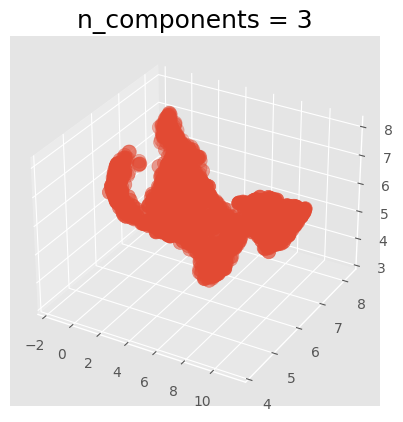

In [18]:
draw_umap(pl_data, n_components=3, title='n_components = 3')

# 

array([[ 5.6962495,  9.37022  ,  7.6308537],
       [ 6.084283 ,  9.52655  ,  7.449932 ],
       [10.6285515,  5.085526 ,  3.313808 ],
       ...,
       [10.677452 ,  3.7351897,  6.4990845],
       [12.285919 ,  3.7485735,  4.712646 ],
       [ 6.1925335, 10.046983 ,  7.098899 ]], dtype=float32)

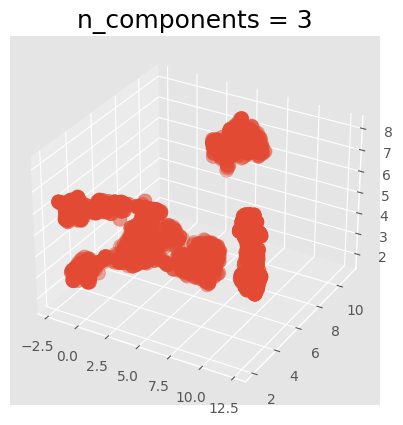

In [19]:
# Ok, let's try something...
draw_umap(pl_data, n_neighbors = 4, min_dist=0.05, n_components=3, title='n_components = 3')

array([[ 4.460338 ,  7.532929 ],
       [ 4.4946704,  7.395057 ],
       [ 9.448869 ,  6.7185206],
       ...,
       [ 9.617205 ,  8.501322 ],
       [10.401609 ,  7.46721  ],
       [ 4.192651 ,  8.334688 ]], dtype=float32)

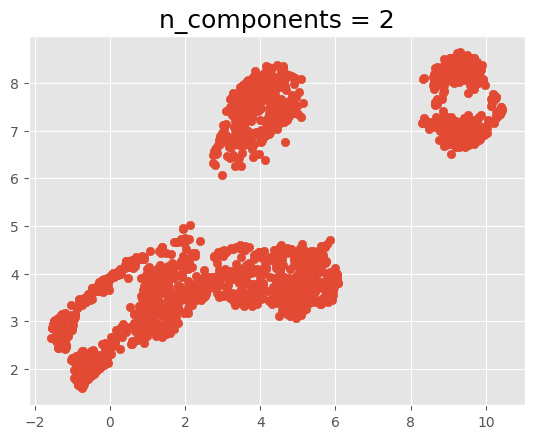

In [31]:

draw_umap(pl_data, n_neighbors =40, min_dist=0.00, n_components=2, title='n_components = 2')

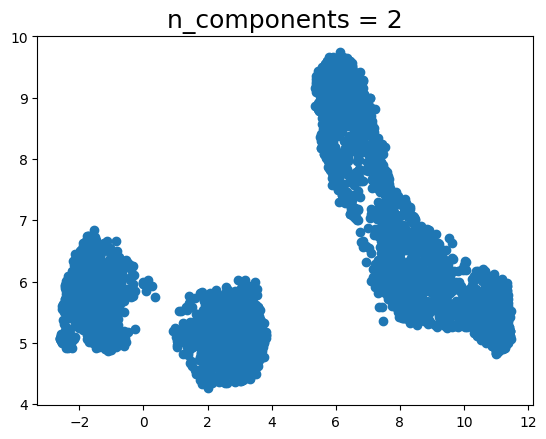

In [22]:
umap_data = draw_umap(pl_data, n_neighbors =37, min_dist=0.01, n_components=2, title='n_components = 2')

In [23]:
# This is the one)
pickle.dump(umap_data, open('../models/data/umap_data.p', "wb"))

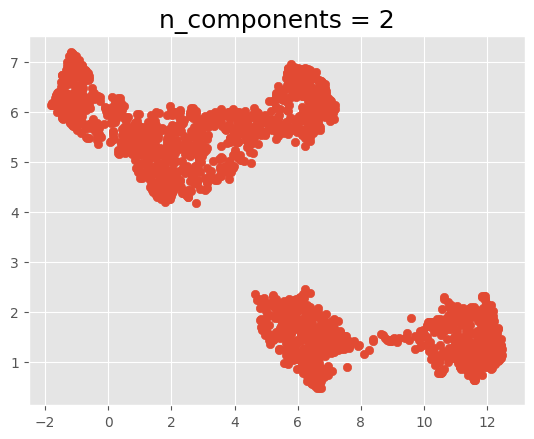

In [23]:
# Let's see what it looks like after PCA
pca_umap_data = draw_umap(pca_data, n_neighbors =35, min_dist=0.00, n_components=2, title='n_components = 2')



It's kind of the same?

In [24]:
gaussian_mapper = umap.UMAP(n_neighbors = 30, min_dist = 0.01, output_metric='gaussian_energy',
                            n_components=5,
                            random_state=42).fit(pl_data)

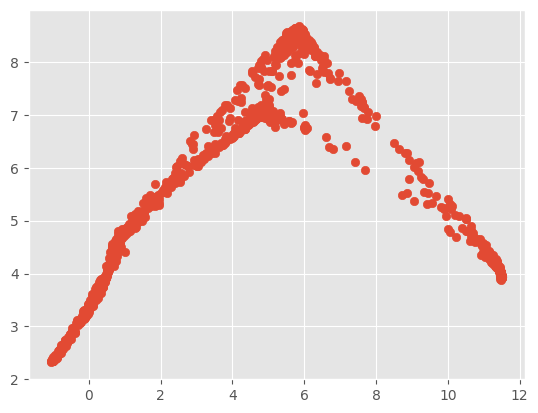

In [25]:
plt.scatter(gaussian_mapper.embedding_.T[0], gaussian_mapper.embedding_.T[1])

So our data has been normalized to be sort of Gaussian...Is that why it looks like this?
What's plotted here is the 2d locations of the modes of the Gaussians.

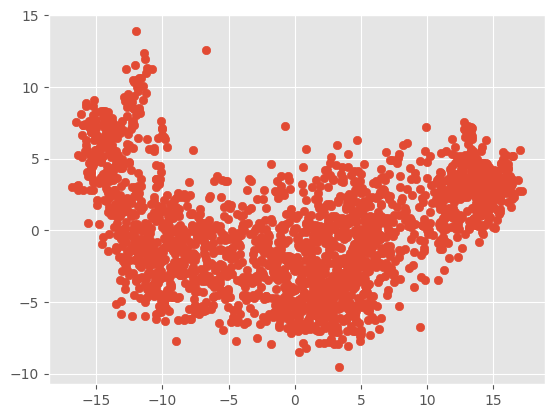

In [26]:
# Isomap?
iso = Isomap(n_neighbors = 40, n_components=2)
iso_fit = iso.fit_transform(pl_data)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(iso_fit[:,0], iso_fit[:,1])


In [27]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(df_trans)
# plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=mnist.target.astype(int), s=0.1, cmap='Spectral')
clustered = (hdb_labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=hdb_labels[clustered],
            s=0.1,
            cmap='Spectral')
plt.show()

NameError: name 'df_trans' is not defined

For n_clusters = any, the best silhouette_score is : 1; the best Davies-Bouldin score is : 0; a good Calinski-Harabsz score is 1000.
For n_clusters = 2, the average silhouette_score is : 0.33; the Davies-Bouldin score is : 1.20; the Calinski-Harabsz score is 1388.75.
For n_clusters = 3, the average silhouette_score is : 0.27; the Davies-Bouldin score is : 1.31; the Calinski-Harabsz score is 1156.49.
For n_clusters = 4, the average silhouette_score is : 0.22; the Davies-Bouldin score is : 1.47; the Calinski-Harabsz score is 954.64.
For n_clusters = 5, the average silhouette_score is : 0.22; the Davies-Bouldin score is : 1.70; the Calinski-Harabsz score is 832.69.
For n_clusters = 6, the average silhouette_score is : 0.20; the Davies-Bouldin score is : 1.80; the Calinski-Harabsz score is 715.92.
For n_clusters = 7, the average silhouette_score is : 0.19; the Davies-Bouldin score is : 1.83; the Calinski-Harabsz score is 625.04.
For n_clusters = 8, the average silhouette_score is : 0.17; t

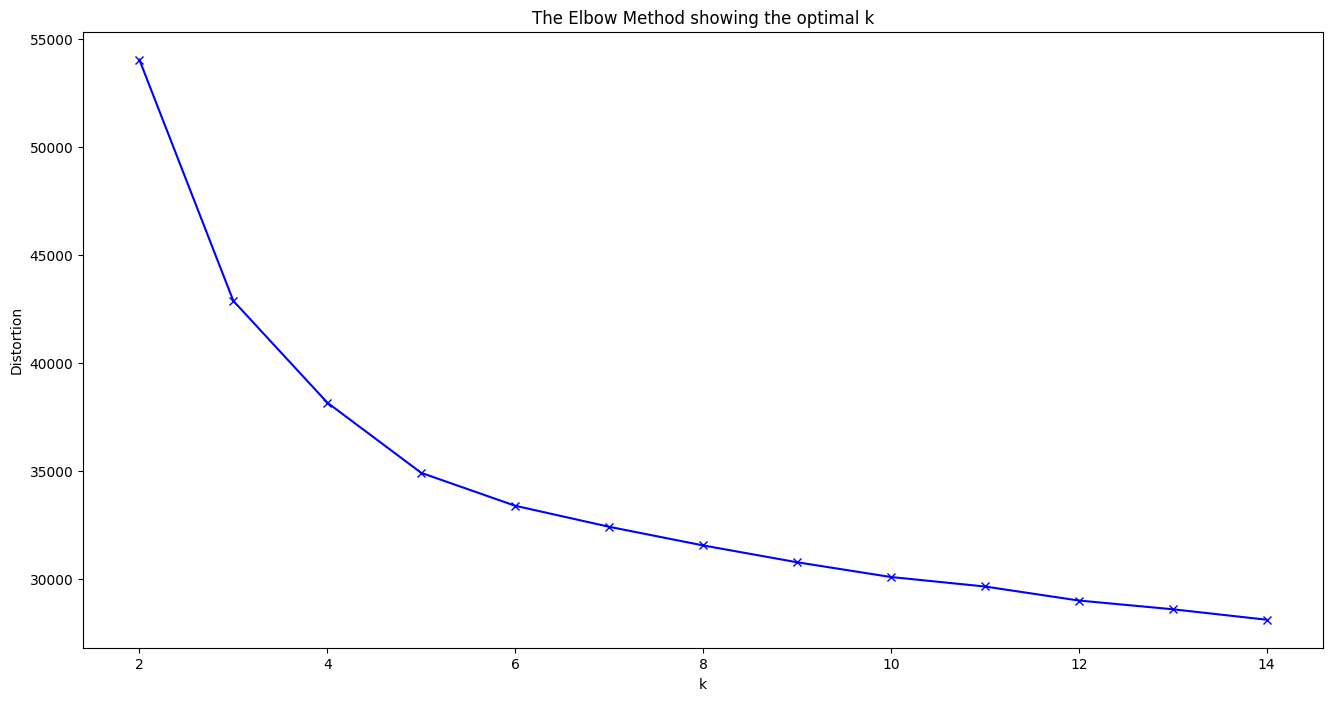

In [ ]:
distortions = []
K = range(2,15)
    
print(f"For n_clusters = any, the best silhouette_score is : 1; the best Davies-Bouldin score is : 0; a good Calinski-Harabsz score is 1000.")
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(pca_data)
    cluster_labels = kmeanModel.fit_predict(pca_data)
    distortions.append(kmeanModel.inertia_)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters. Score ranges from -1 to 1, with 1 being best and -1 being worst.
    silhouette_avg = silhouette_score(pca_data, cluster_labels)
    
    # The Davies-Bouldin score shows clusters that are farther apart and less dispersed
    # Lower scores are better with 0 being best score
    db_score = davies_bouldin_score(pca_data, cluster_labels)
    
    # The Calinsi-Harabsz gives the ratio of between-cluster dispersion and within-cluster dispersion (...kind of).
    # The score is higher when clusters are well-separated (numerator) and dense (denominator)
    # So high scores are better.
    ch_score = calinski_harabasz_score(pca_data, cluster_labels)


    print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg:.2f}; the Davies-Bouldin score is : {db_score:.2f}; the Calinski-Harabsz score is {ch_score:.2f}.")

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# TODO:
# Silhouette, Rand, Dunn, Davies-Bouldin?, Inertia
# Also, Pickle it
# Also, match to validation stuff (positions from FBRef, Goal-scoring stuff?)

In [ ]:
neighbors = 10
player_name = 'Lorenzo Insigne'

# Identify players who are most similar to a given player:
knn = NearestNeighbors(n_neighbors=neighbors)
knn.fit(pca_data)

# If player has changed leagues or teams, they'll be listed twice. Check for that...
# If more than one index, need to choose one

idx = player_data[player_data['Player'] == player_name].index
print(idx)


Int64Index([1497, 1897], dtype='int64')


In [ ]:
neighbor_idx = knn.kneighbors(pca_data[idx], return_distance=False)

# Here, we can see similar players for both instances of an individual
similar_players1 = player_data.iloc[neighbor_idx[0], :]
similar_players1 

,Player,League,Nation,Pos,Squad,Born,90s
1497,Lorenzo Insigne,Serie-A,ITA,FW,Napoli,1991.0,0.668421
1157,Jonas Hofmann,Bundesliga,GER,MF,M'Gladbach,1992.0,0.679412
425,Kevin De Bruyne,Premier-League,BEL,MF,Manchester City,1991.0,0.644737
1119,Chris Führich,Bundesliga,GER,MF,Stuttgart,1998.0,0.558824
1598,Matteo Politano,Serie-A,ITA,FW,Napoli,1993.0,0.481579
833,Aleksandr Golovin,Ligue-1,RUS,FW,Monaco,1996.0,0.439474
2065,Santiago Rodríguez,Major-League-Soccer,URU,MF,NYCFC,2000.0,0.802941
1450,Paulo Dybala,Serie-A,ARG,FW,Juventus,1993.0,0.602632
451,Bruno Fernandes,Premier-League,POR,MF,Manchester Utd,1994.0,0.910526
1083,Julian Brandt,Bundesliga,GER,MF,Dortmund,1996.0,0.679412


In [ ]:
similar_players2 = player_data.iloc[neighbor_idx[1], :]
similar_players2

,Player,League,Nation,Pos,Squad,Born,90s
1897,Lorenzo Insigne,Major-League-Soccer,ITA,FW,Toronto FC,1991.0,0.302941
1402,Antonio Candreva,Serie-A,ITA,MF,Sampdoria,1987.0,0.913158
151,Oussama Idrissi,La-Liga,MAR,MF,Cádiz,1996.0,0.263158
1706,Thiago Almada,Major-League-Soccer,ARG,MF,Atlanta Utd,2001.0,0.776471
1743,Sebastián Blanco,Major-League-Soccer,ARG,MF,Portland Timbers,1988.0,0.594118
1794,Douglas Costa,Major-League-Soccer,BRA,MF,LA Galaxy,1990.0,0.458824
1672,Daniele Verde,Serie-A,ITA,FW,Spezia,1996.0,0.571053
52,Sergio Canales,La-Liga,ESP,FW,Betis,1991.0,0.815789
2163,Lucas Zelarayán,Major-League-Soccer,ARM,MF,Columbus Crew,1992.0,0.755882
1391,Josip Brekalo,Serie-A,CRO,FW,Torino,1998.0,0.668421


Try affinity propagtion?


In [ ]:
from sklearn.cluster import AffinityPropagation



Or UMAP?

In [ ]:
import hdbscan


/home/marcjb/anaconda3/envs/player_analysis/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
hdb_labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=20,
).fit_predict(clusterable_embedding)

In [ ]:
print(len(standard_embedding))

2167


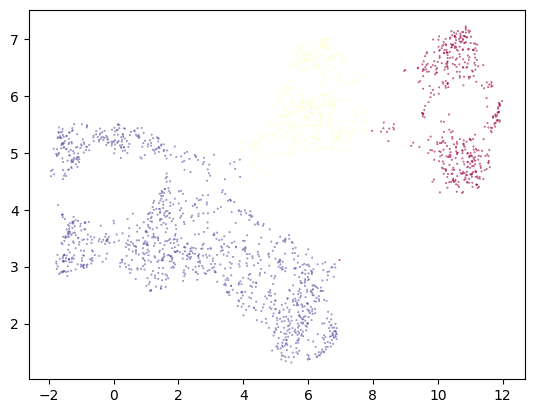

In [ ]:

standard_embedding = umap.UMAP(random_state=42).fit_transform(df_trans)
# plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=mnist.target.astype(int), s=0.1, cmap='Spectral')
clustered = (hdb_labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=hdb_labels[clustered],
            s=0.1,
            cmap='Spectral')
plt.show()

In [ ]:
np.sum(clustered) / df_trans.shape[0]


1.0

In [ ]:

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
n_noise_ = list(hdb_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print(f"The best silhouette_score is : 1; the best Davies-Bouldin score is : 0; a good Calinski-Harabsz score is 1000.")

silhouette_avg = silhouette_score(df_trans, hdb_labels)

db_score = davies_bouldin_score(df_trans, hdb_labels)

ch_score = calinski_harabasz_score(df_trans, hdb_labels)

print(f"The average silhouette_score is : {silhouette_avg:.2f}; the Davies-Bouldin score is : {db_score:.2f}; the Calinski-Harabsz score is {ch_score:.2f}.")


Estimated number of clusters: 3
Estimated number of noise points: 0
The best silhouette_score is : 1; the best Davies-Bouldin score is : 0; a good Calinski-Harabsz score is 1000.
The average silhouette_score is : 0.14; the Davies-Bouldin score is : 1.91; the Calinski-Harabsz score is 515.63.


In [ ]:
from umap.umap_ import nearest_neighbors
# Identify players who are most similar to a given player:
# knn = NearestNeighbors(n_neighbors=6)
kneighbors = nearest_neighbors(standard_embedding,
                              n_neighbors = 10,
                              metric="minkowski",
                              metric_kwds=None,
                              angular=False,
                              random_state=None)


idx = player_data[player_data['Player'] == player_name].index
# If player has changed leagues or teams, they'll be listed twice. Check for that...
# If more than one index, need to choose one
neighbor_idx = kneighbors[0][idx]

# Here, we can see similar players for both instances of an individual
similar_players1 = player_data.iloc[neighbor_idx[0], :]
similar_players1 

,Player,League,Nation,Pos,Squad,Born,90s
507,Harry Kane,Premier-League,ENG,FW,Tottenham,1993.0,0.944737
300,Oihan Sancet,La-Liga,ESP,FW,Athletic Club,2000.0,0.415789
557,Bryan Mbeumo,Premier-League,CMR,FW,Brentford,1999.0,0.850000
156,Luis Javier Suárez,La-Liga,COL,FW,Granada,1997.0,0.831579
1752,Brenner,Major-League-Soccer,BRA,FW,FC Cincinnati,2000.0,0.670588
369,Michail Antonio,Premier-League,JAM,FW,West Ham,1990.0,0.868421
1760,Cory Burke,Major-League-Soccer,JAM,FW,Philadelphia,1991.0,0.391176
1246,Karim Onisiwo,Bundesliga,AUT,FW,Mainz 05,1992.0,0.770588
38,Karim Benzema,La-Liga,FRA,FW,Real Madrid,1987.0,0.757895
1467,Manolo Gabbiadini,Serie-A,ITA,FW,Sampdoria,1991.0,0.334211


In [ ]:
hdb_labels

array([1, 1, 0, ..., 0, 0, 1])

In [ ]:
print(kneighbors[0])

[[   0  735    3 ...  375 1887 1944]
 [   1 1116 1298 ...   97 2143   14]
 [   2  941 1221 ... 1731 1242 1499]
 ...
 [2164 1882  911 ...   47 1898 2049]
 [2165 2082  567 ...  196  505 1620]
 [2166 1419 1755 ... 1946  580 1302]]


In [ ]:
idx

Int64Index([507], dtype='int64')

In [ ]:

player_name = 'Richarlison'
idx = player_data[player_data['Player'] == player_name].index
# If player has changed leagues or teams, they'll be listed twice. Check for that...
# If more than one index, need to choose one
neighbor_idx = kneighbors[0][idx]

# Here, we can see similar players for both instances of an individual
similar_players1 = player_data.iloc[neighbor_idx[0], :]
similar_players1 

,Player,League,Nation,Pos,Squad,Born,90s
607,Richarlison,Premier-League,BRA,FW,Everton,1997.0,0.736842
1540,Rey Manaj,Serie-A,ALB,FW,Spezia,1997.0,0.515789
1779,Lucas Cavallini,Major-League-Soccer,CAN,FW,Vancouver,1992.0,0.494118
808,Hugo Ekitike,Ligue-1,FRA,FW,Reims,2002.0,0.371053
212,Miguel,La-Liga,ESP,FW,Alavés,1999.0,0.242105
1473,Cedric Gondo,Serie-A,CIV,FW,Salernitana,1996.0,0.205263
184,Anthony Lozano,La-Liga,HON,FW,Cádiz,1993.0,0.489474
1774,Julián Carranza,Major-League-Soccer,ARG,FW,Philadelphia,2000.0,0.723529
1158,Lucas Höler,Bundesliga,GER,FW,Freiburg,1994.0,0.844118
1921,Patryk Klimala,Major-League-Soccer,POL,FW,NY Red Bulls,1998.0,0.535294


Try Gaussian mixture with UMAP


In [ ]:
gm = GaussianMixture(n_components = 14, random_state=42)
gm_labels=gm.fit_predict(clusterable_embedding)


# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(gm_labels)) - (1 if -1 in gm_labels else 0)
n_noise_ = list(gm_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print(f"The best silhouette_score is : 1; the best Davies-Bouldin score is : 0; a good Calinski-Harabsz score is 1000.")

silhouette_avg = silhouette_score(df_trans, gm_labels)

db_score = davies_bouldin_score(df_trans, gm_labels)

ch_score = calinski_harabasz_score(df_trans, gm_labels)

print(f"The average silhouette_score is : {silhouette_avg:.2f}; the Davies-Bouldin score is : {db_score:.2f}; the Calinski-Harabsz score is {ch_score:.2f}.")


Estimated number of clusters: 14
Estimated number of noise points: 0
The best silhouette_score is : 1; the best Davies-Bouldin score is : 0; a good Calinski-Harabsz score is 1000.
The average silhouette_score is : 0.06; the Davies-Bouldin score is : 3.11; the Calinski-Harabsz score is 227.91.


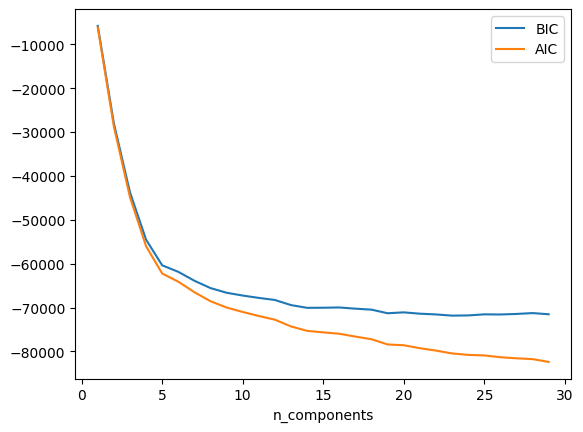

In [ ]:
n_components = np.arange(1, 30)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(clusterable_embedding) for n in n_components]
plt.plot(n_components, [m.bic(clusterable_embedding) for m in models], label='BIC')
plt.plot(n_components, [m.aic(clusterable_embedding) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.show()

In [ ]:

# Identify players who are most similar to a given player:
knn = NearestNeighbors(n_neighbors=6)
kneighbors = nearest_neighbors.fit(standard_embedding)


idx = player_data[player_data['Player'] == player_name].index
# If player has changed leagues or teams, they'll be listed twice. Check for that...
# If more than one index, need to choose one
neighbor_idx = kneighbors(standard_embedding[idx], return_distance=False)

# Here, we can see similar players for both instances of an individual
similar_players1 = player_data.iloc[neighbor_idx[0], :]
similar_players1 

AttributeError: 'function' object has no attribute 'fit'